# CSC 4601 - Final Project
Adam Haile, Alec Nartatez, Dominic Zagra  
11/21/2024

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [172]:
df = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [173]:
# %pip install xgboost
# %pip install graphviz

In [174]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [175]:
num_trees = 4

In [176]:
bst = XGBClassifier(n_estimators=num_trees, max_depth=2, learning_rate=1, objective='binary:logistic')

In [177]:
X_train = df.drop(columns=['label'])
X_train = X_train.drop(columns=X_train.select_dtypes(include='object').columns)
y_train = df['label']

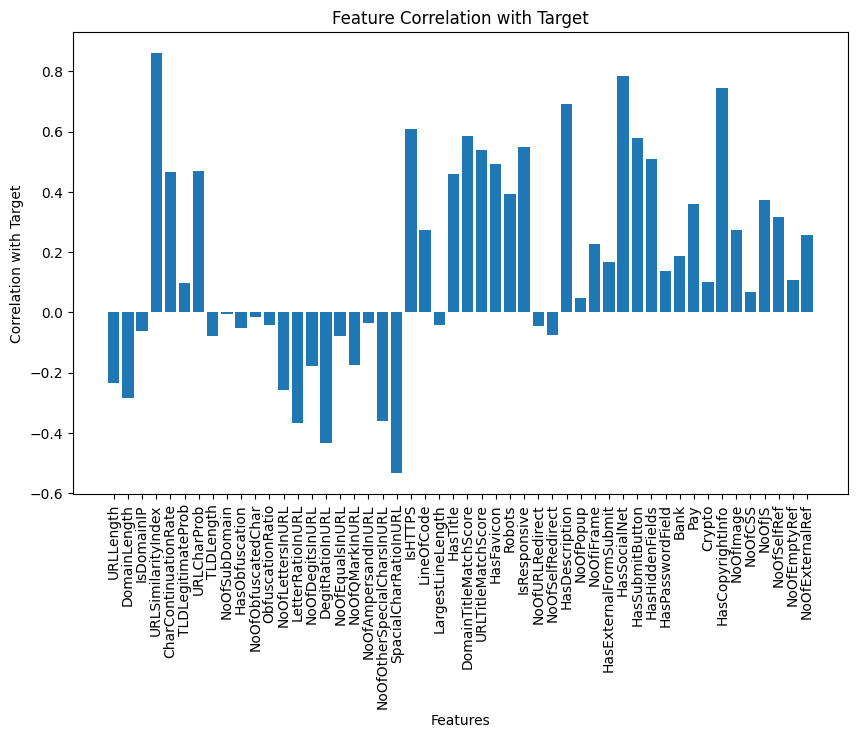

In [178]:
correlation_with_target = X_train.corrwith(y_train)
plt.figure(figsize=(10, 6))
plt.bar(correlation_with_target.index, correlation_with_target.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Feature Correlation with Target')
plt.show()

In [179]:
X_train = X_train.drop(columns=['URLSimilarityIndex', 'LargestLineLength', 'HasTitle', 'HasFavicon', 'URLTitleMatchScore', 'IsResponsive', 'NoOfURLRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasCopyrightInfo', 'HasSocialNet', 'HasPasswordField', 'HasSubmitButton', 'HasHiddenFields', 'Bank', 'Pay', 'Crypto', 'NoOfImage', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'LineOfCode', 'NoOfCSS'])

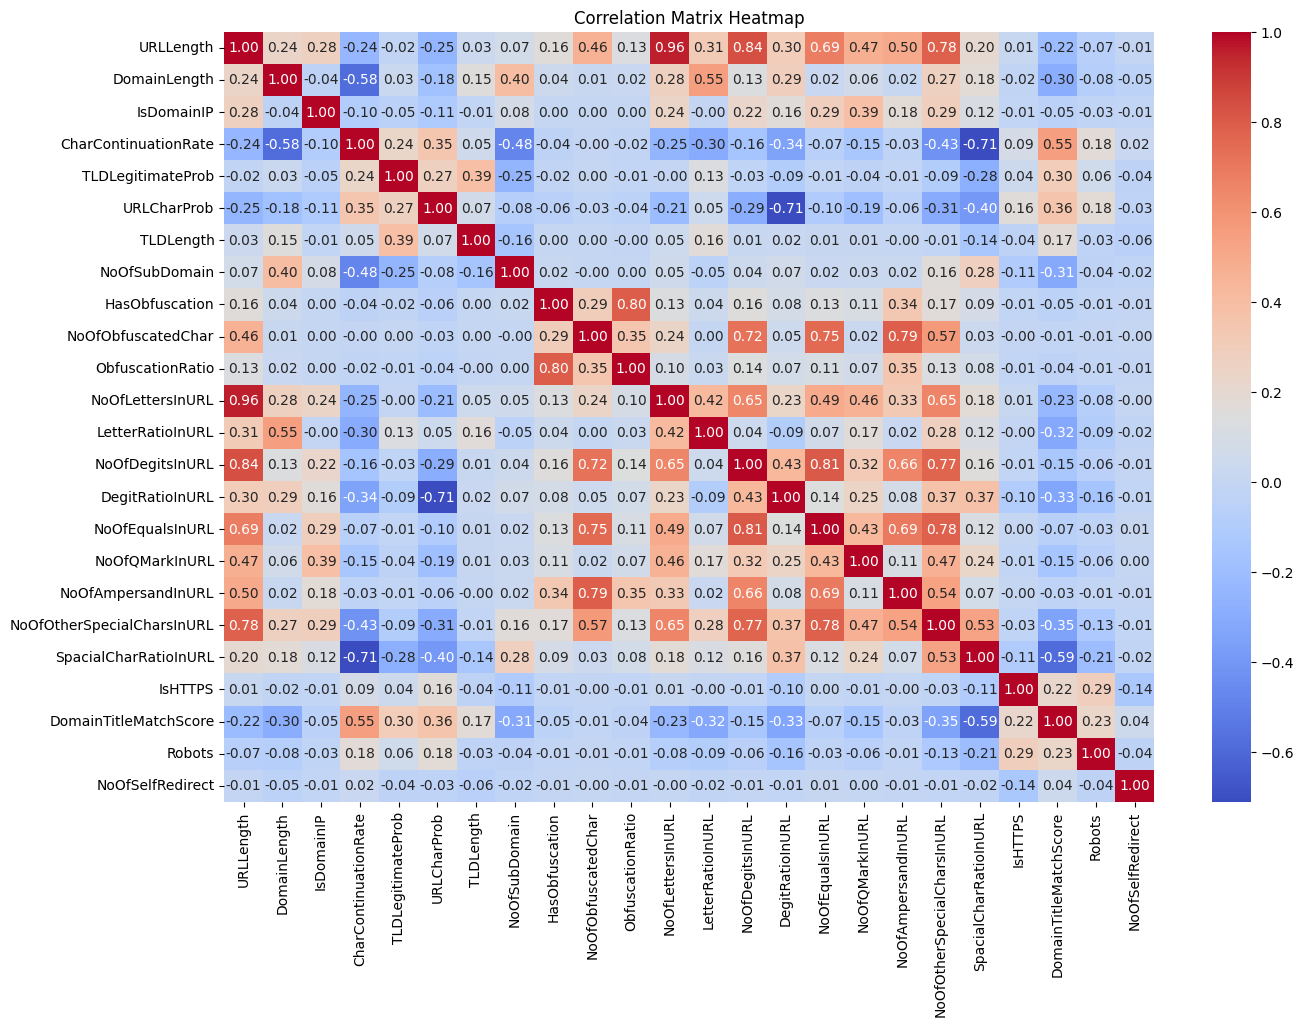

In [180]:
# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

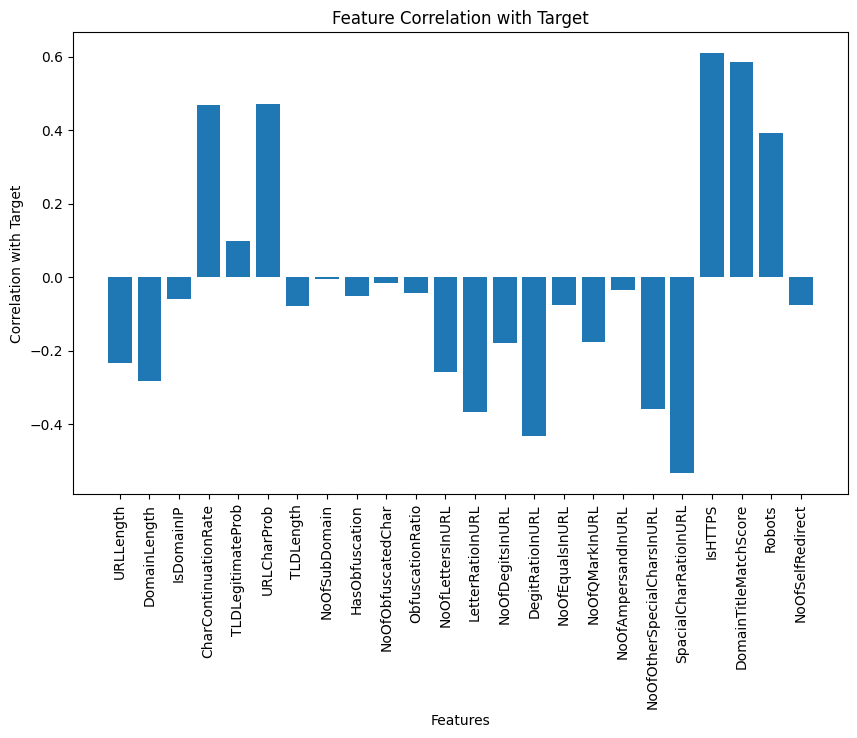

In [181]:
correlation_with_target = X_train.corrwith(y_train)
plt.figure(figsize=(10, 6))
plt.bar(correlation_with_target.index, correlation_with_target.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Feature Correlation with Target')
plt.show()

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2)

In [183]:
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [184]:
preds = bst.predict(X_test)

In [185]:
print((preds == y_test).mean())

0.9844568375071566


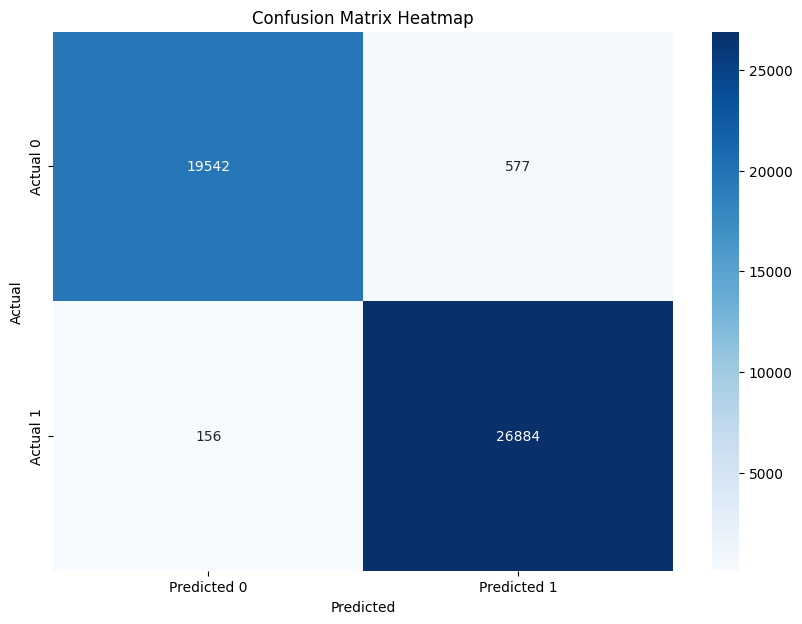

In [186]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, preds)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

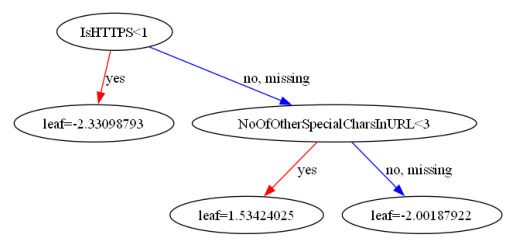

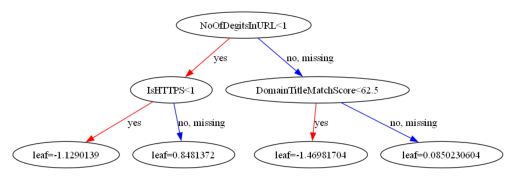

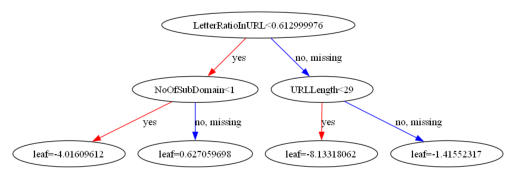

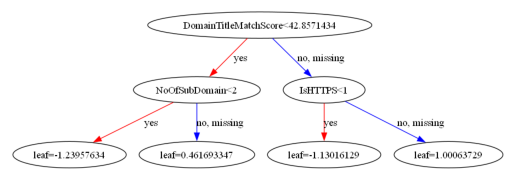

In [187]:
from xgboost import plot_tree

for i in range(num_trees):
    plot_tree(bst, num_trees=i)